# Sweet Lift Taxi

# Contents <a id='back'></a>

* [Introducción](#intro)
* [Etapa 1. Exploracion Datos](#data_review)
* [Etapa 2. Analisis Datos](#a)
* [Etapa 3. Segmentacion](#b)
* [Etapa 4. Modelizacion](#c)
* [Conclusiones](#e)

## Introduccion <a id='intro'></a>

Sweetr Lift Taxi ha recopilado datos hitoricos sobre pedidos de taxis en los aeropuertos. Para traer a mas conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la proxima hora.


## Exploracion Datos <a id='data_review'></a>

In [253]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
from sklearn.preprocessing import LabelBinarizer
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb



In [254]:

# Directorio base
base_dir = '/datasets/'

# Nombre del archivo
archivo = 'taxi.csv'

# Ruta completa
ruta_completa = os.path.join(base_dir, archivo)

# Imprimir la ruta completa
print(ruta_completa)

/datasets/taxi.csv


In [255]:
# Carga el archivo de datos en un DataFrame
try:
    df=pd.read_csv('G:\Mi unidad\Posgrados\Data Sciencia\Proyectos\Proyecto 13- Taxis\df-taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv(ruta_completa, index_col=[0], parse_dates=[0])

In [256]:
#Informacion
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [257]:
#Detalle
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [258]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


## Analisis Datos <a id='a'></a>

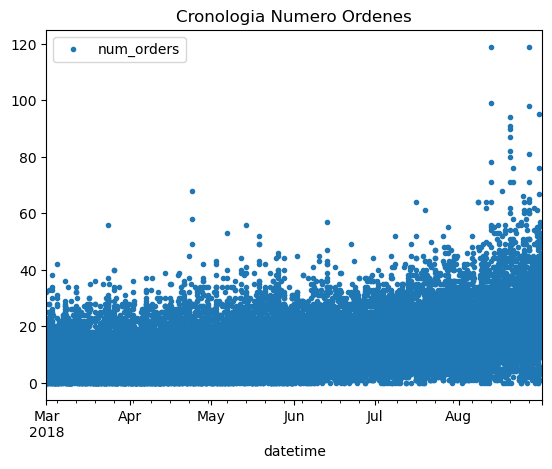

In [259]:
#Recorridos 
df.plot(title='Cronologia Numero Ordenes',style='.')
plt.show()

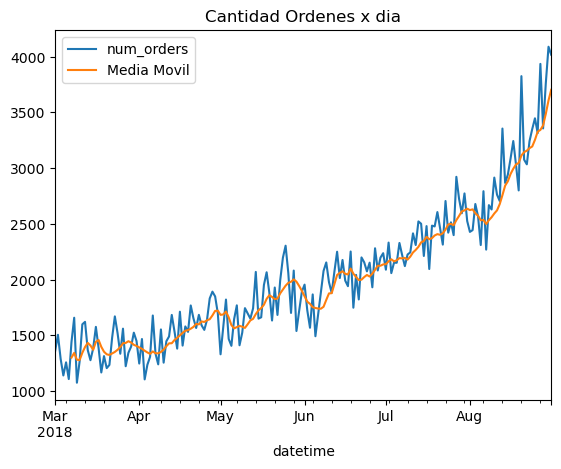

In [260]:
#Recorridos diario con su media movil

df_dia = df.resample('1D').sum()
df_dia['Media Movil'] = df_dia.rolling(7).mean()
df_dia.plot(title='Cantidad Ordenes x dia',style='-')
plt.show()

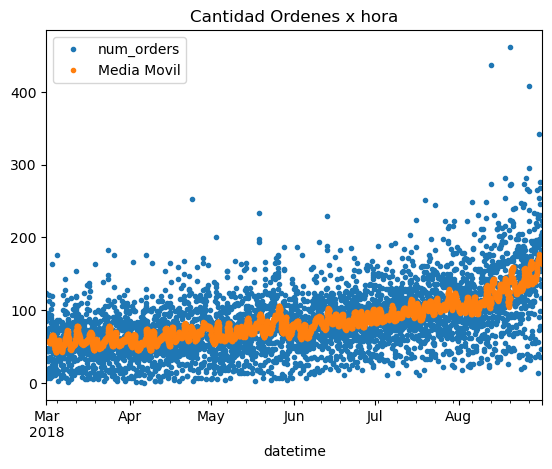

In [261]:
#Recorridos Hora con su media movil

df_hora = df.resample('1H').sum()
df_hora['Media Movil'] = df_hora.rolling(24).mean()
df_hora.plot(title='Cantidad Ordenes x hora',style='.')
plt.show()

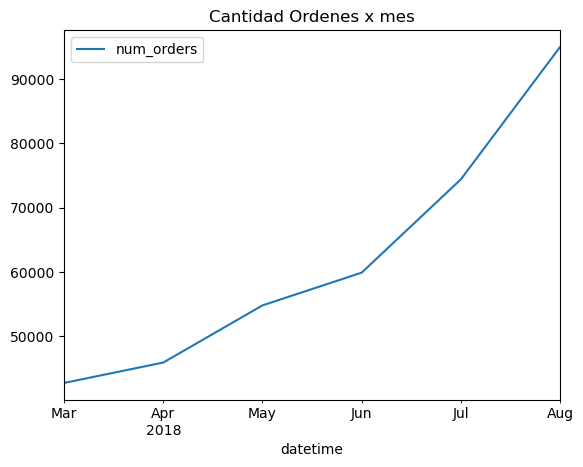

In [262]:
#Recorridos Mensuales

df_mensual = df.resample('1M').sum()
df_mensual.plot(title='Cantidad Ordenes x mes',style='-')
plt.show()

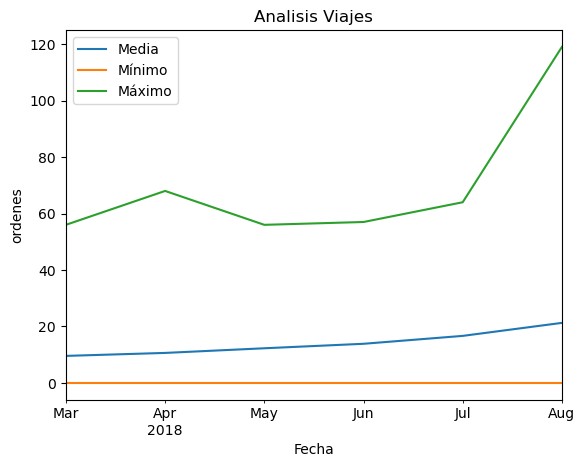

In [263]:
#Promedio Mensuales

df_mensual_mean = df.resample('1M').mean()
df_mensual_min = df.resample('1M').min()
df_mensual_max = df.resample('1M').max()



# Crear una figur
fig, ax = plt.subplots()

# Graficar
df_mensual_mean.plot(ax=ax, label='Media')
df_mensual_min.plot(ax=ax, label='Mínimo')
df_mensual_max.plot(ax=ax, label='Máximo')

# Configurar el título y las etiquetas de los ejes
ax.set_title('Analisis Viajes')
ax.set_xlabel('Fecha')
ax.set_ylabel('ordenes')
ax.legend(labels=['Media', 'Mínimo', 'Máximo'])


plt.show()


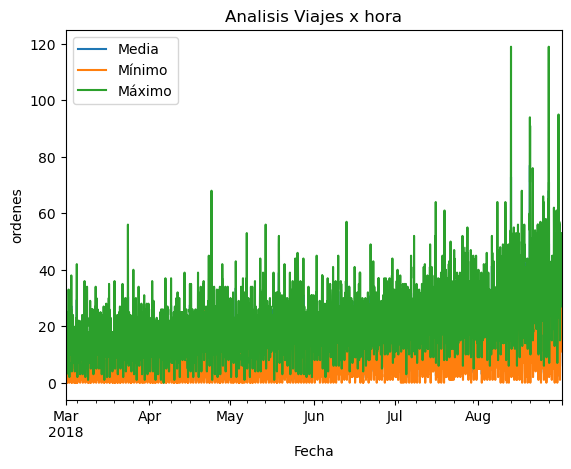

In [264]:
#Promedio x hora

df_hs_mean = df.resample('1H').mean()
df_hs_min = df.resample('1H').min()
df_hs_max = df.resample('1H').max()



# Crear una figur
fig, ax = plt.subplots()

# Graficar
df_hs_mean.plot(ax=ax, label='Media')
df_hs_min.plot(ax=ax, label='Mínimo')
df_hs_max.plot(ax=ax, label='Máximo')

# Configurar el título y las etiquetas de los ejes
ax.set_title('Analisis Viajes x hora')
ax.set_xlabel('Fecha')
ax.set_ylabel('ordenes')
ax.legend(labels=['Media', 'Mínimo', 'Máximo'])


plt.show()


<AxesSubplot:xlabel='hora'>

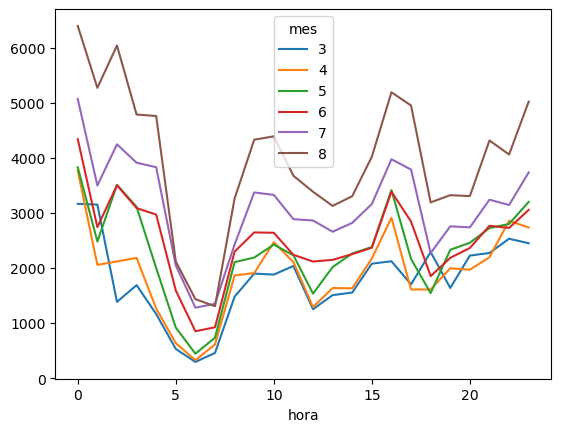

In [265]:
#analisis de la evoulcion mensual de cada hora de trabajo
df_analy=df.copy()
df_analy['mes'] = df_analy.index.month
df_analy['hora'] = df_analy.index.hour

df_month_hour= df_analy.pivot_table(index='hora', columns='mes', values='num_orders', aggfunc='sum')

df_month_hour.plot()

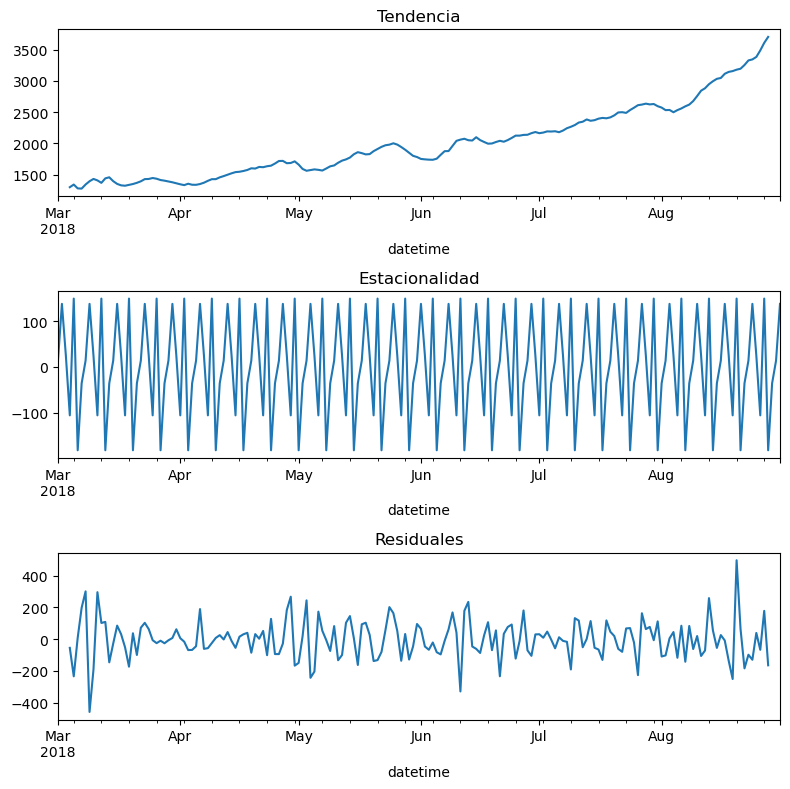

In [266]:
#Analisis de estacionalidad y tendencia
df_dia = df.resample('1D').sum()
decomposed = seasonal_decompose(df_dia)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

# plt.subplot(x,y,z) dice que las imágenes forman una tabla
# de x filas y y columnas.
# z es el lugar de la imagen actual.

# plt.subplot(311) dice 3 filas, 1 columna, primera imagen. 

plt.tight_layout()    # esto ayuda a encajar gráficos secundarios en el área 

<AxesSubplot:xlabel='datetime'>

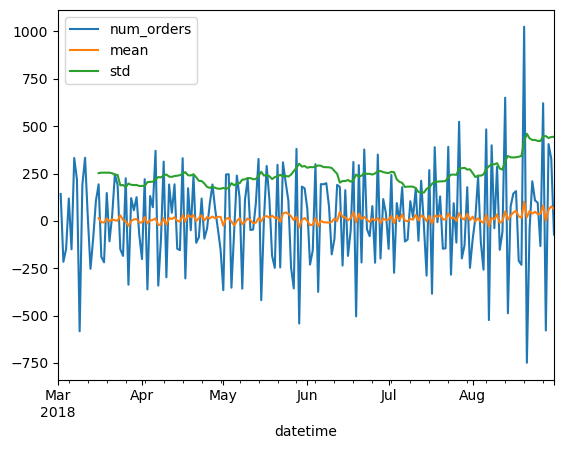

In [267]:
#Diferencia Series Temporales
df_dia = df.resample('1D').sum()
df_dia -= df_dia.shift()
df_dia['mean'] = df_dia['num_orders'].rolling(15).mean()
df_dia['std'] = df_dia['num_orders'].rolling(15).std()
df_dia.plot()

Hay una tendencia creciente del numero de viajes mes a mes, con un comportamiento estacional. 

Al rededor de las 00 horas es el pico de viajes todos los meses, luego comienza a decrecer hasta las 6 a.m donde es el momento de menor actividad. Luego comienza a crecer con picos de actividad al rededor de las 10 a.m y las 4 p.m

## Segmentacion Datos <a id='b'></a>

In [268]:
df_hs=df.resample('1H').sum()

In [269]:
#calcular las caracteristica

df_hs['year'] = df_hs.index.year
df_hs['month'] = df_hs.index.month
df_hs['day'] = df_hs.index.day
df_hs['dayofweek'] = df_hs.index.dayofweek
df_hs['hour'] = df_hs.index.hour


In [270]:
#Dividimos la base de datos para los valores de entregamiento y validacion

df_train, df_valid=train_test_split(df_hs,shuffle=False, test_size=0.10, random_state=12345)

In [271]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  3974 non-null   int64
 1   year        3974 non-null   int64
 2   month       3974 non-null   int64
 3   day         3974 non-null   int64
 4   dayofweek   3974 non-null   int64
 5   hour        3974 non-null   int64
dtypes: int64(6)
memory usage: 217.3 KB


## Modelizacion <a id='c'></a>

##### Variables de Entrenamiento <a id='c1'></a>

In [272]:

features =df_train.drop(['num_orders'], axis=1)
target =df_train['num_orders']

features_valid =df_valid.drop(['num_orders'], axis=1)
target_valid =df_valid['num_orders']


##### Funciones <a id='c1'></a>

In [273]:
def regresion_lineal(feature, target, feature_test, target_test):
    model=LinearRegression()
    model.fit(feature,target)
    predictions_valid=model.predict(feature_test)
    result=(mean_squared_error(target_test,predictions_valid))**0.5
    median=target.mean()
    
    return print('promedio',median,'\n','RECM del modelo de regresion lineal:',result,'\n','R2 =', r2_score(target_test, predictions_valid))

In [274]:
def regresion_lineal_resul(feature, target, feature_test, target_test):
    model=LinearRegression()
    model.fit(feature,target)
    predictions_valid=model.predict(feature_test)
    result=mean_squared_error(target_test,predictions_valid)**0.5
    median=target.mean()
    
    return predictions_valid

### Regresion Lineal <a id='c2'></a>

In [275]:
inicio = time.time()

model=LinearRegression()
model.fit(features,target)

predictions_train=model.predict(features)
predictions_test=model.predict(features_valid)

print('RECM para el conjunto de entrenamiento: ',(mean_squared_error(target,predictions_train))**0.5)
print('RECM para el conjunto de Prueba: ',(mean_squared_error(target_valid,predictions_test))**0.5)

fin = time.time()

print("Tiempo de ejecución:", fin - inicio, "segundos")


RECM para el conjunto de entrenamiento:  34.43111380550365
RECM para el conjunto de Prueba:  63.789001231137846
Tiempo de ejecución: 0.009230375289916992 segundos


In [276]:
RL=LinearRegression().fit(features,target)

In [277]:
# Resultados de Regresión Lineal
nombre_rl = 'Regresión Lineal'
metrica_rl = (mean_squared_error(target_valid,predictions_test))**0.5
tiempo_rl = fin - inicio

### DGE Lineal

####  LightGBM

In [278]:

# Crea un objeto Dataset
train_data = lgb.Dataset(features, label=target)
valid_data = lgb.Dataset(features_valid, label=target_valid)

In [279]:

inicio = time.time()
# Define los parámetros del modelo
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1
}


# Entrena el modelo
model = lgb.train(
    params,
    train_data,
    num_boost_round=10,
    valid_sets=[train_data, valid_data])

# Realiza predicciones en el conjunto de validación
predictions = model.predict(features_valid)
# Calcula el error cuadrático medio
rmse = mean_squared_error(target_valid, predictions, squared=False)
r2=r2_score(target_valid, predictions)
print(f"rmse: {rmse}")
print(f"r2: {r2}")

fin = time.time()

print("Tiempo de ejecución:", fin - inicio, "segundos")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 4
[LightGBM] [Info] Start training from score 78.290639
[1]	training's rmse: 36.3309	valid_1's rmse: 81.2264
[2]	training's rmse: 34.326	valid_1's rmse: 78.0932
[3]	training's rmse: 32.6037	valid_1's rmse: 75.038
[4]	training's rmse: 31.0835	valid_1's rmse: 72.7183
[5]	training's rmse: 29.791	valid_1's rmse: 70.5744
[6]	training's rmse: 28.6739	valid_1's rmse: 68.1913
[7]	training's rmse: 27.7298	valid_1's rmse: 66.2863
[8]	training's rmse: 26.8818	valid_1's rmse: 64.8551
[9]	training's rmse: 26.1426	valid_1's rmse: 62.9858
[10]	training's rmse: 25.5165	valid_1's rmse: 61.2297
rmse: 61.22966155044387
r2: -0.0936433439916986
Tiempo de ejecución: 0.020086050033569336 segundos


In [280]:
DGE=lgb.train(params,train_data,num_boost_round=10,valid_sets=[train_data, valid_data])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 3974, number of used features: 4
[LightGBM] [Info] Start training from score 78.290639
[1]	training's rmse: 36.3309	valid_1's rmse: 81.2264
[2]	training's rmse: 34.326	valid_1's rmse: 78.0932
[3]	training's rmse: 32.6037	valid_1's rmse: 75.038
[4]	training's rmse: 31.0835	valid_1's rmse: 72.7183
[5]	training's rmse: 29.791	valid_1's rmse: 70.5744
[6]	training's rmse: 28.6739	valid_1's rmse: 68.1913
[7]	training's rmse: 27.7298	valid_1's rmse: 66.2863
[8]	training's rmse: 26.8818	valid_1's rmse: 64.8551
[9]	training's rmse: 26.1426	valid_1's rmse: 62.9858
[10]	training's rmse: 25.5165	valid_1's rmse: 61.2297


In [281]:
# Resultados de 'LightGBM'
nombre_LightGBM = 'LightGBM'
metrica_LightGBM = rmse
tiempo_LightGBM = fin - inicio

#### XGBoost

In [282]:
# Crea un objeto DMatrix para los datos de entrenamiento y validacion
train_data = xgb.DMatrix(features, label=target)
valid_data = xgb.DMatrix(features_valid, label=target_valid)

In [283]:
# Define los parámetros del modelo
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

In [284]:
inicio = time.time()
# Entrena el modelo
model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals=[(valid_data, 'valid')],
    verbose_eval=10
)

predictions = model.predict(valid_data)

rmse = mean_squared_error(target_valid, predictions, squared=False)
print(f"RMSE: {rmse}")

fin = time.time()

print("Tiempo de ejecución:", fin - inicio, "segundos")

[0]	valid-rmse:140.96486
[10]	valid-rmse:78.86805
[20]	valid-rmse:55.06148
[30]	valid-rmse:47.53628
[40]	valid-rmse:44.45045
[50]	valid-rmse:42.62604
[60]	valid-rmse:42.22721
[70]	valid-rmse:41.93459
[78]	valid-rmse:41.98357
RMSE: 42.01440081228198
Tiempo de ejecución: 0.14485621452331543 segundos


In [285]:
xgbs=xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals=[(valid_data, 'valid')],
    verbose_eval=10
)

[0]	valid-rmse:140.96486
[10]	valid-rmse:78.86805
[20]	valid-rmse:55.06148
[30]	valid-rmse:47.53628
[40]	valid-rmse:44.45045
[50]	valid-rmse:42.62604
[60]	valid-rmse:42.22721
[70]	valid-rmse:41.93459
[79]	valid-rmse:42.01440


In [286]:
# Resultados de xgbs
nombre_xgbs = 'xgbs'
metrica_xgbs = rmse
tiempo_xgbs = fin - inicio

#### CatBoot

In [287]:
# Crea un objeto Pool para los datos de entrenamiento y validación
train_pool = cb.Pool(features, target)
valid_pool = cb.Pool(features_valid, target_valid)

In [288]:
# Define los parámetros del modelo
params = {
    'iterations': 1000,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'verbose': 10
}

In [289]:
inicio=time.time()

# Entrena el modelo de regresión lineal
model = cb.CatBoostRegressor(iterations=100, loss_function='RMSE', eval_metric='RMSE', verbose=10)
model.fit(features, target, eval_set=(features_valid, target_valid), use_best_model=True)

# Realiza predicciones en el conjunto de validación
predictions = model.predict(features_valid)

# Calcula la métrica de REPM
repm = mean_squared_error(target_valid, predictions, squared=False)
print(f"REPM: {repm}")

fin = time.time()
print("Tiempo de ejecución:", fin - inicio, "segundos")

Learning rate set to 0.257617
0:	learn: 34.4682909	test: 77.5986362	best: 77.5986362 (0)	total: 1.49ms	remaining: 148ms
10:	learn: 24.0011726	test: 54.9686502	best: 54.9686502 (10)	total: 14.8ms	remaining: 120ms
20:	learn: 21.7515118	test: 50.0406700	best: 50.0406700 (20)	total: 26.5ms	remaining: 99.7ms
30:	learn: 20.6286547	test: 47.6508168	best: 47.6508168 (30)	total: 38.6ms	remaining: 85.8ms
40:	learn: 19.8189143	test: 46.2192272	best: 46.2192272 (40)	total: 48.8ms	remaining: 70.3ms
50:	learn: 19.2038881	test: 46.1823131	best: 46.0490515 (48)	total: 61.5ms	remaining: 59ms
60:	learn: 18.6657927	test: 46.4260805	best: 45.8538556 (53)	total: 72.8ms	remaining: 46.5ms
70:	learn: 18.2204775	test: 46.4740401	best: 45.8538556 (53)	total: 82.1ms	remaining: 33.5ms
80:	learn: 17.8934203	test: 46.3373853	best: 45.8538556 (53)	total: 92.5ms	remaining: 21.7ms
90:	learn: 17.5318584	test: 46.3378954	best: 45.8538556 (53)	total: 104ms	remaining: 10.3ms
99:	learn: 17.2808658	test: 46.1218654	best: 45

In [290]:
cat=cb.CatBoostRegressor(iterations=100, loss_function='RMSE', eval_metric='RMSE', verbose=10).fit(features, target, eval_set=(features_valid, target_valid), use_best_model=True)

Learning rate set to 0.257617
0:	learn: 34.4682909	test: 77.5986362	best: 77.5986362 (0)	total: 1.33ms	remaining: 131ms
10:	learn: 24.0011726	test: 54.9686502	best: 54.9686502 (10)	total: 14.1ms	remaining: 114ms
20:	learn: 21.7515118	test: 50.0406700	best: 50.0406700 (20)	total: 24.1ms	remaining: 90.6ms
30:	learn: 20.6286547	test: 47.6508168	best: 47.6508168 (30)	total: 34.6ms	remaining: 76.9ms
40:	learn: 19.8189143	test: 46.2192272	best: 46.2192272 (40)	total: 46.7ms	remaining: 67.2ms
50:	learn: 19.2038881	test: 46.1823131	best: 46.0490515 (48)	total: 56.2ms	remaining: 54ms
60:	learn: 18.6657927	test: 46.4260805	best: 45.8538556 (53)	total: 65.3ms	remaining: 41.8ms
70:	learn: 18.2204775	test: 46.4740401	best: 45.8538556 (53)	total: 74.5ms	remaining: 30.4ms
80:	learn: 17.8934203	test: 46.3373853	best: 45.8538556 (53)	total: 86ms	remaining: 20.2ms
90:	learn: 17.5318584	test: 46.3378954	best: 45.8538556 (53)	total: 97ms	remaining: 9.6ms
99:	learn: 17.2808658	test: 46.1218654	best: 45.853

In [291]:
# Resultados de cat
nombre_cat = 'cat'
metrica_cat = rmse
tiempo_cat = fin - inicio

### Bosque Aleatorio

In [292]:
inicio = time.time()
#Buscar el mejor estimador del modelo
best_score = float('inf')
best_est = 0
best_depth=0

for depth in range(1,10): 
    for est in range(1,10):
        
        model=RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
        model=model.fit(features, target)
        predictions=model.predict(features_valid)
        score = mean_squared_error(target_valid, predictions)**0.5
        r2=r2_score(target_valid, predictions)
        
        if score < best_score:
            best_score = score
            best_est = est
            best_depth=depth

print('Mejor score:', best_score)
print('Mejor valor de max_depth:', best_depth)
print('Mejor valor de max_est:', best_est)

fin = time.time()

print("Tiempo de ejecución:", fin - inicio, "segundos")

Mejor score: 44.66201387991559
Mejor valor de max_depth: 9
Mejor valor de max_est: 2
Tiempo de ejecución: 1.3286750316619873 segundos


In [293]:
bosque=RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=2).fit(features, target)

In [294]:
# Resultados de Random Forest
nombre_rf = 'Random Forest'
metrica_rf= score
tiempo_rf = fin - inicio

### Arbol Aleatorio

In [295]:
inicio = time.time()
#tecnicas de muestreos
best_score = float('inf')
best_est = 0

for est in range(1, 100):
    model = DecisionTreeRegressor(random_state=12345, max_depth=est)
    model=model.fit(features, target)
    predictions=model.predict(features_valid)
    score = mean_squared_error(target_valid, predictions)**0.5
    r2=r2_score(target_valid, predictions)

   
    if score < best_score:
        best_score = score
        best_est = est

print('Mejor score:', best_score)
print('Mejor valor de max_depth:', best_est)

fin = time.time()

print("Tiempo de ejecución:", fin - inicio, "segundos")

Mejor score: 46.03830418780309
Mejor valor de max_depth: 21
Tiempo de ejecución: 1.0081188678741455 segundos


In [296]:
arbol=DecisionTreeRegressor(random_state=12345, max_depth=21).fit(features, target)

In [297]:
resultados_6=[{'modelo':'Arbol','RECM':arbol,'tiempo':fin}]

In [298]:
# Resultados de Random Forest
nombre_arbol = 'Arbol'
metrica_arbol= score
tiempo_arbol = fin - inicio

## Prueba de Cordura

In [299]:
#Calcular los estimadores del test
y_RL = RL.predict(features_valid) # regresion Lineal
y_DGE=DGE.predict(features_valid) # Desenso del gradiente estocastico
y_cat=cat.predict(features_valid)
y_xgbs=xgbs.predict(valid_data)
y_bosque = bosque.predict(features_valid) # Bosque aleatorio
y_arbol = arbol.predict(features_valid)# Arbol

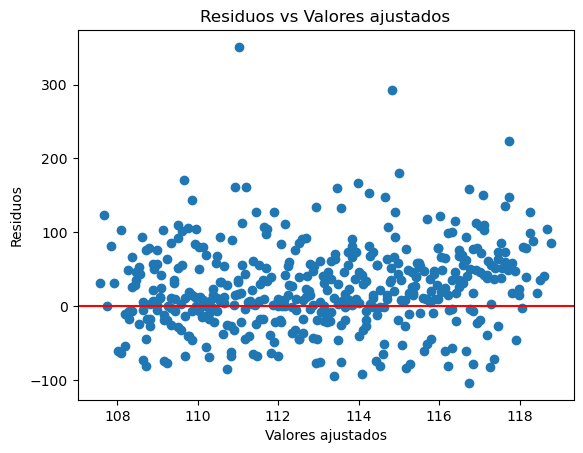

In [300]:
#Regresion Lineal
residuos = target_valid - y_RL

plt.scatter(y_RL, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

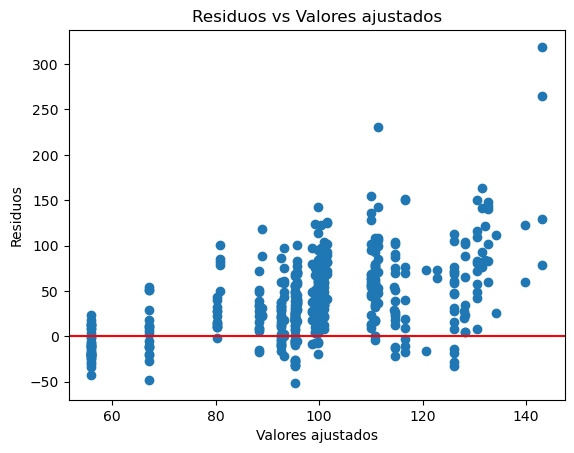

In [301]:
#Regresion Lineal DGE con lightGBM
residuos = target_valid - y_DGE

plt.scatter(y_DGE, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

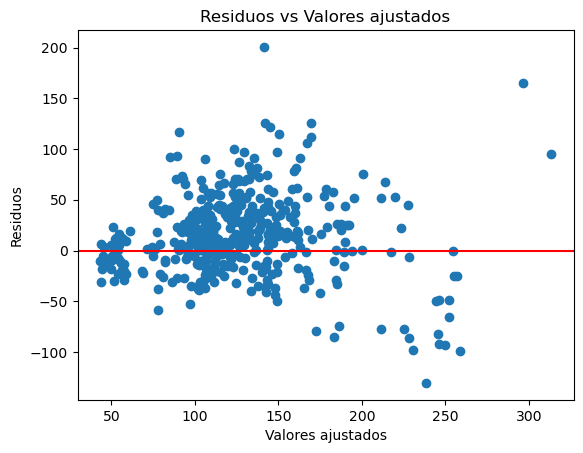

In [302]:
# DGE con xgbs
residuos = target_valid - y_xgbs

plt.scatter(y_xgbs, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

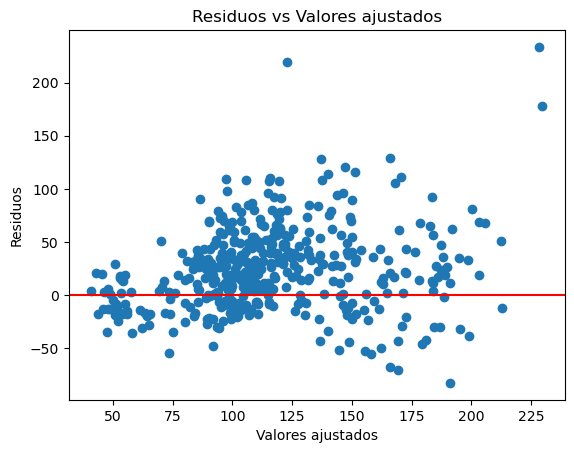

In [303]:
# DGE con catboot
residuos = target_valid - y_cat

plt.scatter(y_cat, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

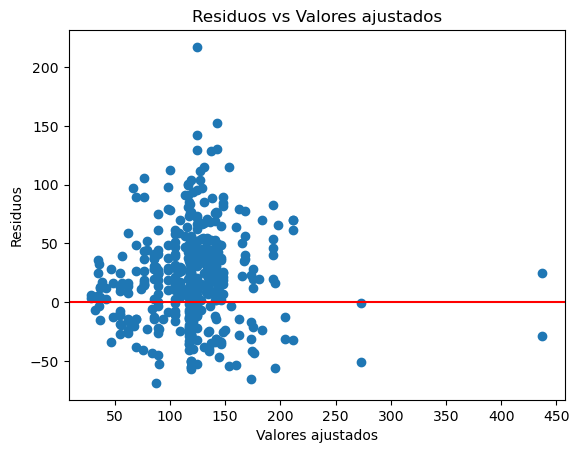

In [304]:
#Bosque Aleatorio
residuos = target_valid - y_bosque

plt.scatter(y_bosque, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

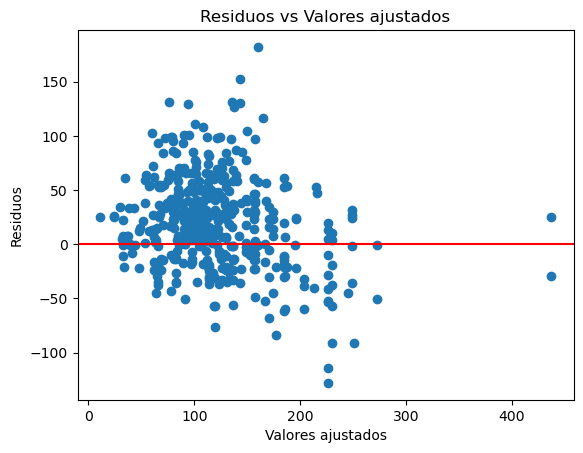

In [305]:
#Arbol
residuos = target_valid - y_arbol

plt.scatter(y_arbol, residuos)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuos vs Valores ajustados')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

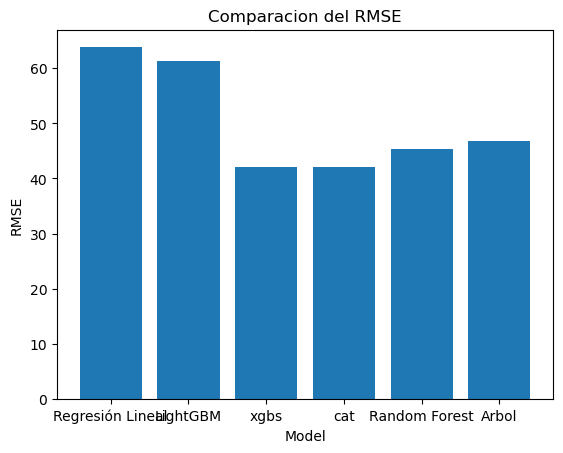

In [306]:
# RMSE para cada modelo
rmse_values = [metrica_rl, metrica_LightGBM, metrica_xgbs, metrica_cat, metrica_rf, metrica_arbol]

model_names = [nombre_rl, nombre_LightGBM, nombre_xgbs, nombre_cat, nombre_rf, nombre_arbol]


plt.bar(model_names, rmse_values,label='rmse')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparacion del RMSE')

# Mostrar gráfico
plt.show()

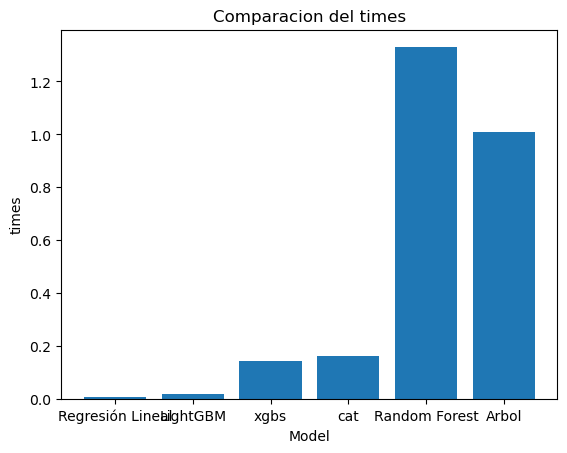

In [307]:
# Time para cada modelo

times_values = [tiempo_rl, tiempo_LightGBM, tiempo_xgbs, tiempo_cat, tiempo_rf, tiempo_arbol]
model_names = [nombre_rl, nombre_LightGBM, nombre_xgbs, nombre_cat, nombre_rf, nombre_arbol]


plt.bar(model_names, times_values,label='times')


plt.xlabel('Model')
plt.ylabel('times')
plt.title('Comparacion del times')

# Mostrar gráfico
plt.show()

## Conclusiones <a id='e'></a>

Se extranjeros los datos y se analizaron, donde se pudo observar que hay una tendencia creciente del numero de viajes mes a mes, con un comportamiento estacional. 

Al rededor de las 00 horas es el pico de viajes todos los meses, luego comienza a decrecer hasta las 6 a.m donde es el momento de menor actividad. Luego comienza a crecer con picos de actividad al rededor de las 10 a.m y las 4 p.m

Luego se cargaron las caracteristicas a la base de datos para poder efectuar las predicciones de las proximas horas. Se segmento la base dejando un 10% para realizar las pruebas.

Se utilizaron para el entrenamiento 4 modelos tradicionales y 3 con el método del descenso del gradiente estocástico. En estos últimos se estudiaron los parámetros que mejor optimizaban el modelo en función de la métrica del RECM. También se compararon los tiempos de ejecución de cada uno. 

Y se obtuvieron las siguientes conclusiones:
El mejor modelo que predice los resultados es el descenso del gradiente con la librería de Xgbs teniendo un RECM de 42 y con un tiempo de 0.14 Segundos.
